In [44]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline


# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [45]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [46]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

<AxesSubplot:xlabel='Date'>

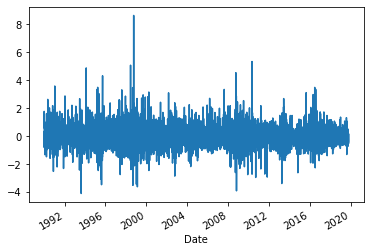

In [47]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s

returns = yen_futures.Settle.pct_change() * 100
returns.plot()


### Lagged Returns 

In [51]:
# Create a lagged return using the shift function
yen_futures['Return'] = returns.copy()
yen_futures['Lagged_Return'] = returns.shift()
# Drop NaN values
yen_futures = yen_futures.dropna()
yen_futures.tail()


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.369458
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335,-0.564304
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509,0.151335


### Train Test Split

In [52]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2018']
test = yen_futures['2018':]
test.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2018-01-02,8909.5,8957.5,8898.5,8938.0,26.5,8940.5,96714.0,227884.0,0.297285,0.224871
2018-01-03,8943.0,8947.5,8913.0,8921.0,21.5,8919.0,93498.0,226582.0,-0.240479,0.297285
2018-01-04,8917.0,8920.5,8891.0,8901.0,19.0,8900.0,115434.0,224918.0,-0.213028,-0.240479
2018-01-05,8897.0,8902.0,8854.0,8878.0,31.5,8868.5,133023.0,229326.0,-0.353933,-0.213028
2018-01-08,8870.5,8889.0,8849.5,8872.5,5.5,8874.0,81647.0,237100.0,0.062017,-0.353933


In [53]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
y_train = train["Return"]
X_test = test["Lagged_Return"].to_frame()
y_test = test["Return"]

In [54]:
X_train

,Lagged_Return
Date,
2014-02-18,0.409123
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
...,...
2018-12-24,-0.187545
2018-12-26,0.834485
2018-12-27,-0.893346


# Linear Regression Model

In [55]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

In [56]:
model = LinearRegression()
model

LinearRegression()

In [62]:

model.fit(X_train,y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [65]:
# Make a prediction of "y" values using just the test dataset
predicted_y_values = model.predict(X_test)
predicted_y_values

array([-6.70674117e-03, -7.56823410e-03, -1.17062066e-03, -1.49718917e-03,
        1.79105453e-04, -4.76932324e-03, -8.65667506e-03, -1.78532439e-02,
       -6.80372229e-03, -4.22907675e-03, -1.20640476e-02,  4.66651765e-03,
       -5.08561043e-03, -8.24414062e-03,  2.97410469e-04, -1.12069315e-02,
       -1.78382597e-02,  1.08258216e-04, -1.21452668e-02, -1.06589120e-03,
       -5.84120115e-03, -3.53130321e-04, -5.35921723e-04,  5.12277815e-03,
       -1.01162873e-02, -7.80701180e-03, -3.25285835e-03, -9.68053791e-03,
       -7.39198885e-03, -2.74267655e-03, -1.47405490e-02, -1.08088097e-02,
       -1.29955271e-02, -3.33743325e-03,  6.70157854e-03,  1.63872794e-03,
       -1.65786192e-02, -2.89126447e-03, -2.00245203e-03,  1.55795518e-03,
       -1.23276845e-02, -8.34100143e-03, -1.18616199e-02,  3.43371025e-03,
       -3.84213528e-03, -5.79942161e-03, -1.88797405e-03,  1.90545639e-03,
       -8.47485179e-03, -1.24896588e-03, -7.83481437e-03, -3.90515047e-03,
       -5.73773123e-03, -

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

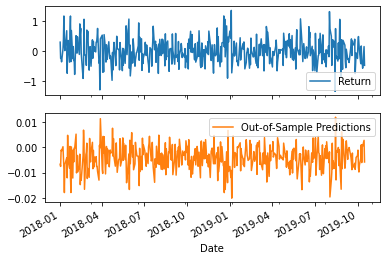

In [68]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
 # Construct a dataframe using just the "y" training data:
out_of_sample_results = y_test.to_frame()

# Add a column of "out-of-sample" predictions to that dataframe:  
out_of_sample_results["Out-of-Sample Predictions"] = model.predict(X_test) 
out_of_sample_results.plot(subplots=True) 


array([<AxesSubplot:xlabel='Date'>], dtype=object)

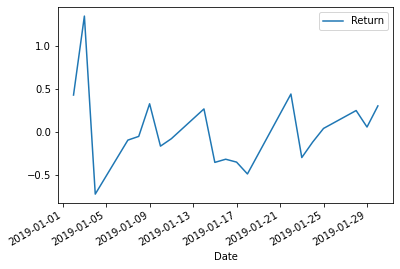

In [69]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [70]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
out_of_sample_mse = mean_squared_error(
    out_of_sample_results["Return"],
    out_of_sample_results["Out-of-Sample Predictions"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
out_of_sample_rmse = np.sqrt(out_of_sample_mse)
print(f"Out-of-sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")

Out-of-sample Root Mean Squared Error (RMSE): 0.4151933603075715


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [71]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.5657562717010388


# Conclusions

YOUR CONCLUSIONS HERE!

The RMSE is near 1 so I think this In-Sample works well.